## Import necessary library

In [103]:
import datetime
import os

import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

In [104]:
now = datetime.datetime.now()
now = now.strftime('%Y-%m-%d_%H-%M-%S')
print(f"Time of execution: {now}")

Time of execution: 2025-01-11_16-20-45


In [105]:
CURRENT_DIR = os.getcwd()
print('CURRENT DIRECTORY: ', CURRENT_DIR)

DATASET_DIR = '/kaggle/input/defectxray' if CURRENT_DIR.split('/')[1] == 'kaggle' else CURRENT_DIR
print('DATASET DIRECTORY: ', DATASET_DIR)

config = {
        'name': "gdxray",
        'data_dir': os.path.join(DATASET_DIR, "data/gdxray"),
        'metadata': os.path.join(DATASET_DIR, "metadata"),
        'subset': "train",
        'labels': True,
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'image_size': (224, 224),
        'learning_rate': 3e-4,
        'batch_size': 2,
        'epochs': 100,
        'save_dir': os.path.join(CURRENT_DIR, "logs/gdxray")
   }

CURRENT DIRECTORY:  /kaggle/working
DATASET DIRECTORY:  /kaggle/input/defectxray


## Gather all function in other file 

## Model structure

In [106]:
import torch
import torch.nn.functional as F

class SAM(nn.Module):
    def __init__(self, bias=False):
        super(SAM, self).__init__()
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3, dilation=1, bias=self.bias)

    def forward(self, x):
        max = torch.max(x,1)[0].unsqueeze(1)
        avg = torch.mean(x,1).unsqueeze(1)
        concat = torch.cat((max,avg), dim=1)
        output = self.conv(concat)
        output = F.sigmoid(output) * x
        return output

class CAM(nn.Module):
    def __init__(self, channels, r):
        super(CAM, self).__init__()
        self.channels = channels
        self.r = r
        self.linear = nn.Sequential(
            nn.Linear(in_features=self.channels, out_features=self.channels//self.r, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=self.channels//self.r, out_features=self.channels, bias=True))

    def forward(self, x):
        max = F.adaptive_max_pool2d(x, output_size=1)
        avg = F.adaptive_avg_pool2d(x, output_size=1)
        b, c, _, _ = x.size()
        linear_max = self.linear(max.view(b,c)).view(b, c, 1, 1)
        linear_avg = self.linear(avg.view(b,c)).view(b, c, 1, 1)
        output = linear_max + linear_avg
        output = F.sigmoid(output) * x
        return output

class CBAM(nn.Module):
    def __init__(self, channels, r):
        super(CBAM, self).__init__()
        self.channels = channels
        self.r = r
        self.sam = SAM(bias=False)
        self.cam = CAM(channels=self.channels, r=self.r)

    def forward(self, x):
        output = self.cam(x)
        output = self.sam(output)
        return output

class ResHDCCBAM(nn.Module):
    def __init__(self, in_channels, output_channels, r=16):
        super(ResHDCCBAM, self).__init__()

        self.branch1 = nn.Conv2d(in_channels, output_channels, kernel_size=3, padding=1, dilation=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, dilation=1),
            nn.Conv2d(in_channels, output_channels, kernel_size=3, padding=2, dilation=2)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, dilation=1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=2, dilation=2),
            nn.Conv2d(in_channels, output_channels, kernel_size=3, padding=4, dilation=4)
        )

        self.cbam = CBAM(in_channels, r)
        self.conv1 = nn.Conv2d(in_channels, output_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, output_channels, kernel_size=1)

    def forward(self, x):
        residual = x
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        cbam = self.cbam(x)
        out = out1 + out2 + out3 + self.conv1(cbam) + self.conv2(residual)
        return out

class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSampling, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

def SimAM(X, lamb):
    # spatial size
    n = X.shape[2] * X.shape[3]- 1
    # square of (t- u)
    d = (X- X.mean(dim=[2,3])).pow(2)
    # d.sum() / n is channel variance
    v = d.sum(dim=[2,3]) / n
    # E_inv groups all importance of X
    E_inv = d / (4 * (v + lamb)) + 0.5
    # return attended features
    return X * nn.Sigmoid(E_inv)

class ResSimAM(nn.Module):
    def __init__(self, in_channels, lamb):
        super(ResSimAM, self).__init__()

        self.lamb = lamb
        self.conv1 = ConvBNReLU(in_channels, in_channels, 3, 1, 1, 1)
        self.conv2 = ConvBNReLU(in_channels, in_channels, 3, 1, 1, 1, use_relu=False)

        self.simam = SimAM

    def forward(self, X):
        residual = X
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.simam(X, self.lamb)
        return nn.ReLU(X + residual)

class DCIM(nn.Module):
    def __init__(self, output_list, num_parallel, r=16):
        super(DCIM, self).__init__()
        self.levels = len(output_list)
        self.num_parallel = num_parallel

        # Initialize convolutional, upsampling, and downsampling layers
        self.H = nn.ModuleDict()
        self.D = nn.ModuleDict()
        self.U = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        for k in range(self.num_parallel):
            for level in range(self.levels):
                idx = f"{level}_{k}"
                input_channels = output_list[level] if level != 0 else 0 # Downsampled input channels
                input_channels += 0 if k == 0 or level == self.levels - 1 else output_list[level] + output_list[level+1] # Skip connection and Upsampling

                input_channels = output_list[level] if input_channels == 0 else input_channels

                # print(f"Level {l}, Branch {k}, Input channels: {input_channels}")

                self.H[idx] = ResHDCCBAM(input_channels, output_list[level], r)

                if level < self.levels - 1:
                    # self.D[idx] = DownSampling(input_channels, output_list[l+1])
                    self.D[idx] = DownSampling(output_list[level], output_list[level+1])
                # if k < self.num_parallel - 1:
                #     self.U[f"{l+1}_{k}"] = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Initilize tensor storage
        X = {}

        for k in range(self.num_parallel):
            for lvl in range(self.levels):
                idx = f"{lvl}_{k}"

                if lvl == 0:
                    if k == 0:
                        X[idx] = self.H[idx](x)
                    else:
                        U = self.U(X[f"{lvl+1}_{k-1}"])
                        X[idx] = self.H[idx](torch.cat([X[f"{lvl}_{k-1}"], U], dim = 1))

                elif lvl > 0 and lvl < self.levels - 1:
                    if k == 0:
                        D = self.D[f"{lvl-1}_{k}"](X[f"{lvl-1}_{k}"])
                        X[idx] = self.H[idx](D)
                    else:
                        D = self.D[f"{lvl-1}_{k}"](X[f"{lvl-1}_{k}"])
                        U = self.U(X[f"{lvl+1}_{k-1}"])
                        X[idx] = self.H[idx](torch.cat([X[f"{lvl}_{k-1}"], D, U], dim = 1))
                elif lvl == self.levels - 1:
                    D = self.D[f"{lvl-1}_{k}"](X[f"{lvl-1}_{k}"])
                    X[idx] = self.H[idx](D)

        return [X[f"{lvl}_{self.num_parallel-1}"] for lvl in range(self.levels)]

class AFF(nn.Module):
    """
    Adaptive Feature Fusion (AFF) module for semantic segmentation
    """
    def __init__(self, in_channels, out_channels):
        super(AFF, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x1, x2):
        x2 = nn.Upsample(size=x1.size()[2:], mode='bilinear', align_corners=True)(x2)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

class CARAFE(nn.Module):
    # CARAFE: Content-Aware ReAssembly of FEatures "https://arxiv.org/pdf/1905.02188.pdf"
    """
    Args:
        input_channels (int): input feature channels
        scale_factor (int): upsample ratio
        up_kernel (int): kernel size of CARAFE op
        up_group (int): group size of CARAFE op
        encoder_kernel (int): kernel size of content encoder
        encoder_dilation (int): dilation of content encoder

    Returns:
        upsampled feature map
    """
    def __init__(self, input_channels, scale_factor=2, kernel_up=5, kernel_encoder=3):
        super(CARAFE, self).__init__()
        self.scale_factor = scale_factor
        self.kernel_up = kernel_up
        self.kernel_encoder = kernel_encoder
        self.down = nn.Conv2d(input_channels, input_channels // 4, 1)
        self.encoder = nn.Conv2d(input_channels // 4, self.scale_factor ** 2 * self.kernel_up ** 2,self.kernel_encoder, 1, self.kernel_encoder // 2)
        self.out = nn.Conv2d(input_channels, input_channels, 1)

    def forward(self, x):
        N, C, H, W = x.size()
        # N,C,H,W -> N,C,delta*H,delta*W
        # kernel prediction module
        kernel_tensor = self.down(x)  # (N, Cm, H, W)
        kernel_tensor = self.encoder(kernel_tensor)  # (N, S^2 * Kup^2, H, W)
        kernel_tensor = F.pixel_shuffle(kernel_tensor, self.scale_factor)  # (N, S^2 * Kup^2, H, W)->(N, Kup^2, S*H, S*W)
        kernel_tensor = F.softmax(kernel_tensor, dim=1)  # (N, Kup^2, S*H, S*W)
        kernel_tensor = kernel_tensor.unfold(2, self.scale_factor, step=self.scale_factor) # (N, Kup^2, H, W*S, S)
        kernel_tensor = kernel_tensor.unfold(3, self.scale_factor, step=self.scale_factor) # (N, Kup^2, H, W, S, S)
        kernel_tensor = kernel_tensor.reshape(N, self.kernel_up ** 2, H, W, self.scale_factor ** 2) # (N, Kup^2, H, W, S^2)
        kernel_tensor = kernel_tensor.permute(0, 2, 3, 1, 4)  # (N, H, W, Kup^2, S^2)

        # content-aware reassembly module
        # tensor.unfold: dim, size, step
        x = F.pad(x, pad=(self.kernel_up // 2, self.kernel_up // 2,
                                          self.kernel_up // 2, self.kernel_up // 2),
                          mode='constant', value=0) # (N, C, H+Kup//2+Kup//2, W+Kup//2+Kup//2)
        x = x.unfold(2, self.kernel_up, step=1) # (N, C, H, W+Kup//2+Kup//2, Kup)
        x = x.unfold(3, self.kernel_up, step=1) # (N, C, H, W, Kup, Kup)
        x = x.reshape(N, C, H, W, -1) # (N, C, H, W, Kup^2)
        x = x.permute(0, 2, 3, 1, 4)  # (N, H, W, C, Kup^2)

        out_tensor = torch.matmul(x, kernel_tensor)  # (N, H, W, C, S^2)
        out_tensor = out_tensor.reshape(N, H, W, -1)
        out_tensor = out_tensor.permute(0, 3, 1, 2)
        out_tensor = F.pixel_shuffle(out_tensor, self.scale_factor)

        out_tensor = self.out(out_tensor)
        #print("up shape:",out_tensor.shape)
        return out_tensor

class ConvBNReLU(nn.Module):
    '''Module for the Conv-BN-ReLU tuple.'''
    def __init__(self, c_in, c_out, kernel_size, stride, padding, dilation,
                 use_relu=True):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(
                c_in, c_out, kernel_size=kernel_size, stride=stride,
                padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(c_out)
        if use_relu:
            self.relu = nn.ReLU(inplace=True)
        else:
            self.relu = None

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class AdaptiveThresholdPrediction(nn.Module):
    def __init__(self, in_channels=64, pool_size=(1, 1), num_classes=2):
        """
        Adaptive Threshold Prediction Module.
        Args:
            in_channels (int): Number of input channels.
            intermediate_channels (int): Number of intermediate channels (e.g., 64).
            pool_size (tuple): Adaptive pooling output size (default 1x1).
        returns:
            torch.Tensor: Thresholded output tensor of the same shape as the input tensor.
        """
        super(AdaptiveThresholdPrediction, self).__init__()

        # First path: Conv1x1 -> STAF
        self.conv1x1_main = nn.Conv2d(in_channels, num_classes, kernel_size=1)

        # Second path: Adaptive Max Pool -> Conv1x1 -> Threshold prediction
        self.adaptive_pool = nn.AdaptiveMaxPool2d(output_size=pool_size)
        self.conv1x1_thresh = nn.Conv2d(in_channels, num_classes, kernel_size=1)

        # Learnable scalar for threshold prediction
        self.sigma = nn.Parameter(torch.tensor(1.0))  # Scale factor (learnable)

    def forward(self, x):
        """
        Forward pass of the Adaptive Threshold Prediction Module.
        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)
        Returns:
            torch.Tensor: Thresholded output tensor.
        """
        # First path
        main_output = self.conv1x1_main(x)  # Output: (B, 64, H, W)

        # Second path for threshold prediction
        pooled_output = self.adaptive_pool(x)  # Output: (B, C, 1, 1)
        threshold = self.conv1x1_thresh(pooled_output)  # Output: (B, 64, 1, 1)
        threshold = torch.sigmoid(threshold) * self.sigma  # Sigmoid to predict Thresh

        # Broadcast threshold to match main_output shape
        threshold = F.interpolate(threshold, size=main_output.shape[2:], mode='bilinear', align_corners=False)

        # Apply threshold (modulation or scaling)
        output = main_output * threshold

        # assert output.shape[1] == 2, f"Output shape: {output.shape}"

        return output


class WResHDC_FF(nn.Module):
    def __init__(self, num_classes, input_channels, output_list, num_parallel, channel_ratio=16, upsample_cfg=dict(type='carafe', scale_factor = 2, kernel_up = 5, kernel_encoder = 3, compress_channels = 64)):
        """
        The overall architecture of the WResHDC-FF models for semantic segmentation.
        It contains the following components:
            1. ResHDCCBAM: Residual Hierarchical Dense Convolutional Channel Attention Block
            2. AFF: Adaptive Feature Fusion
            3. CARAFE: Content-Aware ReAssembly of FEatures

        Args:
            num_classes (int): Number of classes for the segmentation task
            output_list (list): List of output channels for each level
            num_parallel (int): Number of parallel branches in each level
            r (int): Reduction ratio for the channel attention module
            upsample_cfg (dict): Configuration for the upsampling module
        """
        super(WResHDC_FF, self).__init__()

        self.levels = len(output_list) # 5
        self.num_parallel = num_parallel # 1
        self.channel_ratio = channel_ratio

        # First convolutional layer as compress layer
        # self.conv1 = ConvBNReLU(input_channels, output_list[0], 3, 1, 1, 1)
        self.conv1 = nn.Conv2d(input_channels, output_list[0], kernel_size=1, stride=1)

        # Initialize DCIM module
        self.dcim = DCIM(output_list, num_parallel)

        self.aff = nn.ModuleList()
        # Initialize AFF module
        for level in range(self.levels - 2):
            self.aff.append(AFF(output_list[level] + output_list[level+1], output_list[level]))

        # Initialize CARAFE module
        self.upsample = nn.ModuleList()
        self.convbnrelu1 = nn.ModuleList()
        self.convbnrelu2 = nn.ModuleList()
        for level in range(self.levels - 1, 0, -1):
            if upsample_cfg['type'] == 'carafe':
                self.upsample.append(CARAFE(output_list[level],
                                            upsample_cfg['scale_factor'],
                                            upsample_cfg['kernel_up'],
                                            upsample_cfg['kernel_encoder']))
            else:
                self.upsample.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True))

            self.convbnrelu1.append(ConvBNReLU(output_list[level] + output_list[level-1], output_list[level], 3, 1, 1, 1))
            self.convbnrelu2.append(ConvBNReLU(output_list[level], output_list[level-1], 3, 1, 1, 1))

        # Adaptive Threshold Prediction Module
        self.atp = AdaptiveThresholdPrediction(in_channels=output_list[0], pool_size=(1, 1), num_classes=num_classes)

    def forward(self, x):

        x = self.conv1(x)  # 3*320*320 -> 64*320*320
        # DCIM module
        X = self.dcim(x) # levels of feature maps
        F = X.copy()
        # delete two last levels
        del F[self.levels-1]

        # Adaptive Feature Fusion module
        for level in range(self.levels - 2): # 0, 1, 2
            F[level] = self.aff[level](X[level], X[level+1])

        # Upsampling module
        # out = self.upsample[0](X[self.levels - 1]) # W*H*1024 -> 2W*2H*1024
        # out = torch.cat([out, X[self.levels - 2]], dim=1)
        # out = self.convbnrelu1[0](out)
        # out = self.convbnrelu2[0](out) # 2W*2H*1024 -> 2W*2H*512

        # out = self.upsample[1](out) # 2W*2H*512 -> 4W*4H*512
        # out = torch.cat([out, F[self.levels - 3]], dim=1)
        # out = self.convbnrelu1[1](out)
        # out = self.convbnrelu2[1](out) # 4W*4H*512 -> 4W*4H*256

        # out = self.upsample[2](out)
        # out = torch.cat([out, F[self.levels - 4]], dim=1)
        # out = self.convbnrelu1[2](out)
        # out = self.convbnrelu2[2](out)

        # out = self.upsample[3](out)
        # out = torch.cat([out, F[self.levels - 5]], dim=1)
        # out = self.convbnrelu1[3](out)
        # out = self.convbnrelu2[3](out)

        out = X[self.levels - 1]
        for level in range(self.levels - 1, 0, -1):
            out = self.upsample[self.levels - 1 - level](out)
            out = torch.cat([out, F[level-1]], dim=1)
            out = self.convbnrelu1[self.levels - 1 - level](out)
            out = self.convbnrelu2[self.levels - 1 - level](out)

        return self.atp(out)


## Utils function

In [107]:
import copy
import os
import json
import math
import random

import numpy as np

from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torchvision.utils import draw_segmentation_masks

BACKGROUND_CLASS = 0
WELDING_DEFECT = 1
OBJECT_CLASSES = [BACKGROUND_CLASS, WELDING_DEFECT]


# Base Configuration Class
# Don't use this class directly. Instead, sub-class it and override
# the configurations you need to change.


class Config(object):
    """Base configuration class. For custom configurations, create a
    sub-class that inherits from this one and override properties
    that need to be changed.
    """

    # Name the configurations. For example, 'COCO', 'Experiment 3', ...etc.
    # Useful if your code needs to do things differently depending on which
    # experiment is running.
    NAME = None  # Override in sub-classes

    # NUMBER OF GPUs to use. For CPU training, use 1
    GPU_COUNT = 1

    # Number of images to train with on each GPU. A 12GB GPU can typically
    # handle 2 images of 1024x1024px.
    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 2

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 1000

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 50

    # Number of classification classes (including background)
    NUM_CLASSES = 2  # Override in sub-classes

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (128, 128)  # (height, width) of the mini-mask

    # Input image resing
    # Images are resized such that the smallest side is >= IMAGE_MIN_DIM and
    # the longest side is <= IMAGE_MAX_DIM. In case both conditions can't
    # be satisfied together the IMAGE_MAX_DIM is enforced.
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 512
    # If True, pad images with zeros such that they're (max_dim by max_dim)
    IMAGE_PADDING = True  # currently, the False option is not supported

    # Image mean (RGB)
    MEAN_PIXEL = np.array([123.7, 116.8, 103.9])

    # Learning rate and momentum
    # The Mask RCNN paper uses lr=0.02, but on TensorFlow it causes
    # weights to explode. Likely due to differences in optimzer
    # implementation.
    LEARNING_RATE = 0.001
    LEARNING_MOMENTUM = 0.9

    # Weight decay regularization
    WEIGHT_DECAY = 0.0001

    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        self.IMAGE_SHAPE = np.array([self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM, 3])

        # Compute backbone size from input image size
        self.BACKBONE_SHAPES = np.array(
            [
                [
                    int(math.ceil(self.IMAGE_SHAPE[0] / stride)),
                    int(math.ceil(self.IMAGE_SHAPE[1] / stride)),
                ]
                for stride in self.BACKBONE_STRIDES
            ]
        )

    def display(self):
        """Display Configuration values."""
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")

class GDXrayDataset(Dataset):
    """
    Dataset of Xray Images

    Images are referred to using their image_id (relative path to image).
    An example image_id is: "Weldings/W0001/W0001_0004.png"
    """

    def __init__(self, config: dict, labels: bool, transform):
        super().__init__()
        """
        Args:
            config (dict): Contain nessesary information for the dataset
            config = {
                'name': str, # Name of the dataset
                'data_dir': str, # Path to the data directory
                'subset': str, # 'train' or 'val'
                'metadata': str, # Path to the metadata file
                }
            labels (bool): Whether to load labels
            transform (callable, optional): Transform to be applied to the images.
        """

        self.config = config
        self.labels = labels
        self.transform = transform

        # Initialize the dataset infos
        self.image_info = []
        self.image_indices = {}
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]

        # Add classes
        self.add_class(config["name"], 1, "Defect")

        # Load the dataset
        metadata_img = "{}/{}_{}.txt".format(config['metadata'], config["name"], "images")
        metadata_label = "{}/{}_{}.txt".format(config['metadata'], config["name"], "labels") if labels else None

        # Load image ids from key 'image' in dictionary in metadata file
        image_ids = []
        image_ids.extend(self.load_metadata(metadata_img, "image"))
        if self.labels:
            label_ids = []
            label_ids.extend(self.load_metadata(metadata_label, "label"))

        for i, image_id in enumerate(image_ids):
            img_path = os.path.join(config["data_dir"], image_id)
            label_path = ""
            if self.labels:
                label_path = os.path.join(config["data_dir"], label_ids[i])

                if not os.path.exists(label_path):
                    print("Skipping ", image_id, " Reason: No mask")

                    del self.image_ids[i]
                    del self.label_ids[i]

                    continue

            print("Adding image: ", image_id)

            self.add_image(config["name"], config['subset'], image_id, img_path, label=label_path)

    def __len__(self):
        return len(self.image_indices)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the data to fetch.

        Returns:
            tuple: (image, label) where both are transformed.
        """

        image_path = self.image_info[idx]["path"]
        # image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # self.update_info(idx, height_org=image.shape[0], width_org=image.shape[1])
        image = Image.open(image_path).convert('RGB')
        width, height = image.size
        self.update_info(idx, height_org=width, width_org=height)

        if self.labels:
            label_path = self.image_info[idx]["label"]
            # label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            label = Image.open(label_path).convert('L') # read as grayscale

        if self.transform:
            image, label = self.transform(image, label) if self.labels else self.transform(image)

        if self.labels:
            return image, v2.ToTensor()(label).squeeze(0)

    def add_class(self, source, class_id, class_name):
        assert "." not in source, "Source name cannot contain a dot"
        # Does the class exist already?
        for info in self.class_info:
            if info["source"] == source and info["id"] == class_id:
                # source.class_id combination already available, skip
                return
        # Add the class
        self.class_info.append(
            {
                "source": source,
                "id": class_id,
                "name": class_name,
            }
        )

    def add_image(self, source, subset, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "subset": subset,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)
        self.image_indices[image_id] = len(self.image_info) - 1

    def update_info(self, image_id, **kwargs):
        info = self.image_info[image_id]
        info.update(kwargs)
        self.image_info[image_id] = info

    def load_metadata(self, metadata, key):
        """
        metadata file has the following format:
        {
            "image": [<image_id>, <image_id>, ...],
            "label": [<label_id>, <label_id>, ...]
        }

        Args:
            metadata (str): Path to the metadata file
            key (str): Key to load from the metadata file
        """

        image_ids = []
        with open(metadata, "r") as metadata_file:
            image_ids += metadata_file.readlines()
        return [p.rstrip() for p in image_ids]


def visualize_samples(dataset, num_samples=3, labels=True):
    """
    Visualize random samples from the dataset with images in the first column and labels in the second.

    Args:
        dataset (Dataset): The PyTorch Dataset to visualize.
        num_samples (int): Number of random samples to visualize.
    """

    # Print a message notifying that the transformation is applied
    print("CAUTION!!!! Be careful with normalization...") if dataset.transform is not None else None

    # Randomly select indices
    indices = random.sample(range(len(dataset)), num_samples)

    # Set up the Matplotlib figure
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is iterable for a single sample

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image_path = dataset.image_info[idx]["path"]
        label_path = dataset.image_info[idx]["label"]

        image, label = v2.ToTensor()(image), v2.ToTensor()(label)
        image_mask = draw_segmentation_masks(image, label.bool(), alpha=0.5)

        image = image.permute(1, 2, 0).numpy()
        image_mask = image_mask.permute(1, 2, 0).numpy()

        # Display the image
        axes[i][0].imshow(image)
        axes[i][0].set_title(
            f"Image: {image_path.split('/')[-1].split('.')[0]} -- Size: {image.shape}"
        )
        axes[i][0].axis("off")

        # Display the label
        axes[i][1].imshow(image_mask)
        axes[i][1].set_title(
            f"Label: {label_path.split('/')[-1].split('.')[0]} -- Size: {label.shape}"
        )
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.show()

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    # get transform from dataset and remove normalization
    transform = dataset.transform.transforms[:-1]
    dataset.transform = v2.Compose(transform)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols * 2, figsize=(12, 6))
    for i in range(samples):
        image, mask = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        mask = mask.permute(1, 2, 0).numpy()
        ax.ravel()[i * 2].imshow(image)
        ax.ravel()[i * 2].set_title("Image")
        ax.ravel()[i * 2].set_axis_off()
        ax.ravel()[i * 2 + 1].imshow(mask, cmap='gray')
        ax.ravel()[i * 2 + 1].set_title("Mask")
        ax.ravel()[i * 2 + 1].set_axis_off()
    plt.tight_layout()
    plt.show()

def save_metrics(save_dir, prefix, train_losses, train_dcs, valid_losses, valid_dcs):
    metrics = {
        'train_losses': train_losses,
        'train_dcs': train_dcs,
        'valid_losses': valid_losses,
        'valid_dcs': valid_dcs
    }

    with open(os.path.join(save_dir, f"metrics_{prefix}.json"), 'w') as f:
        json.dump(metrics, f)

## Metrics

In [108]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)

    return dice

## Losses

In [109]:
def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.

    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """
    shape = np.array(input.shape)
    shape[1] = num_classes
    shape = tuple(shape)
    result = torch.zeros(shape)
    result = result.scatter_(1, input.cpu(), 1)

    return result


class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

def dice_loss(pred, target, epsilon=1e-6):
    # Flatten the tensors for Dice coefficient calculation
    pred = pred.view(-1)
    target = target.view(-1)
    
    # Calculate intersection and Dice coefficient
    intersection = (pred * target).sum()
    dice = (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)
    
    return 1 - dice


## Augmentation

In [110]:
from torchvision.transforms.functional import InterpolationMode

def torch_train_transform(size=(224, 224), scale=(0.08, 1.0), rotation=30, flip=0.5):
    image_transforms = v2.Compose([
        # v2.ToImage(),
        # v2.RandomCrop(size),  # Random crop of size 256x256
        v2.Resize(size),
        v2.RandomRotation(degrees=rotation, interpolation=InterpolationMode.BILINEAR),  # Random rotation within 30 degrees
        # v2.RandomResize(size=size, scale=scale),  # Random rescale and crop
        v2.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Random affine transformation
        v2.RandomHorizontalFlip(p=flip),  # Random horizontal flip
        v2.GaussianBlur(kernel_size=3),  # Apply Gaussian blur
        # v2.RandomErasing(p=0.5),  # Random cutout
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
        v2.ToDtype(torch.float32, scale=True),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return image_transforms

def torch_valid_transform(size=(224, 224)):
    image_transforms = v2.Compose([
        v2.Resize(size),
        v2.ToDtype(torch.float32, scale=True),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return image_transforms


## Load dataset

In [111]:
transform_train = torch_train_transform(config['image_size'])
transform_valid = torch_valid_transform(config['image_size'])

train_dataset = GDXrayDataset(config, labels=config['labels'], transform=transform_train)
valid_dataset = GDXrayDataset(config, labels=config['labels'], transform=transform_valid)

Adding image:  welding/W0001/W0001_0000.png
Adding image:  welding/W0001/W0001_0001.png
Adding image:  welding/W0001/W0001_0002.png
Adding image:  welding/W0001/W0001_0003.png
Adding image:  welding/W0001/W0001_0004.png
Adding image:  welding/W0001/W0001_0005.png
Adding image:  welding/W0001/W0001_0006.png
Adding image:  welding/W0001/W0001_0007.png
Adding image:  welding/W0001/W0001_0008.png
Adding image:  welding/W0001/W0001_0009.png
Adding image:  welding/W0001/W0001_0010.png
Adding image:  welding/W0001/W0001_0011.png
Adding image:  welding/W0001/W0001_0012.png
Adding image:  welding/W0001/W0001_0013.png
Adding image:  welding/W0001/W0001_0014.png
Adding image:  welding/W0001/W0001_0015.png
Adding image:  welding/W0001/W0001_0016.png
Adding image:  welding/W0001/W0001_0017.png
Adding image:  welding/W0001/W0001_0018.png
Adding image:  welding/W0001/W0001_0019.png
Adding image:  welding/W0001/W0001_0020.png
Adding image:  welding/W0001/W0001_0021.png
Adding image:  welding/W0001/W00

In [112]:
if config['device'] == "cuda":
    num_workers = torch.cuda.device_count() * 4

In [113]:
train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=config['batch_size'],
                              shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset,
                              num_workers=num_workers, pin_memory=False,
                              batch_size=config['batch_size'],
                              shuffle=True)

## Create model and opt and loss

In [114]:
output_list = [32, 64, 128, 256, 512]
num_parallel = 2
num_classes = 1
upsampling_cfg = dict(type='carafe', scale_factor=2, kernel_up=5, kernel_encoder=3)
model = WResHDC_FF(num_classes, 3, output_list, num_parallel, upsample_cfg=upsampling_cfg)
model.to(config['device'])

optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'])
criterion = nn.BCEWithLogitsLoss()

In [115]:
torch.cuda.empty_cache()

## Train model

In [116]:
train_losses = []
train_dcs = []
valid_losses = []
valid_dcs = []

for epoch in tqdm(range(config['epochs'])):
    model.train()
    train_running_loss = 0.0
    train_running_dc = 0.0
    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].to(config['device'], dtype=torch.float32)
        mask = img_mask[1].to(config['device'], dtype=torch.long)
        y_pred = model(img)
        optimizer.zero_grad()
        dc = dice_coefficient(y_pred.squeeze(1), mask.float())
        loss = criterion(y_pred.squeeze(1), mask.float())
        loss += dice_loss(F.sigmoid(y_pred.squeeze(1)), mask.float())
        train_running_loss += loss.item()
        train_running_dc += dc.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)
    train_losses.append(train_loss)
    train_dcs.append(train_dc)
    model.eval()
    val_running_loss = 0.0
    val_running_dc = 0.0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(valid_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(config['device'])
            mask = img_mask[1].float().to(config['device'])

            y_pred = model(img)
            loss = criterion(y_pred.squeeze(1), mask)
            loss += dice_loss(F.sigmoid(y_pred.squeeze(1)), mask)
            dc = dice_coefficient(y_pred.squeeze(1), mask)
            val_running_loss += loss.item()
            val_running_dc += dc.item()
        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)
    valid_losses.append(val_loss)
    valid_dcs.append(val_dc)
    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

  1%|          | 1/100 [00:12<21:00, 12.73s/it]

------------------------------
Training Loss EPOCH 1: 1.6780
Training DICE EPOCH 1: 0.0021


Validation Loss EPOCH 1: 1.6599
Validation DICE EPOCH 1: 0.0383
------------------------------


  2%|▏         | 2/100 [00:25<20:47, 12.73s/it]

------------------------------
Training Loss EPOCH 2: 1.6388
Training DICE EPOCH 2: 0.0027


Validation Loss EPOCH 2: 1.6364
Validation DICE EPOCH 2: 0.0084
------------------------------


  3%|▎         | 3/100 [00:38<20:34, 12.73s/it]

------------------------------
Training Loss EPOCH 3: 1.5947
Training DICE EPOCH 3: 0.0013


Validation Loss EPOCH 3: 1.5239
Validation DICE EPOCH 3: 0.0275
------------------------------


  4%|▍         | 4/100 [00:50<20:20, 12.72s/it]

------------------------------
Training Loss EPOCH 4: 1.5293
Training DICE EPOCH 4: 0.0016


Validation Loss EPOCH 4: 1.5264
Validation DICE EPOCH 4: 0.0078
------------------------------


  5%|▌         | 5/100 [01:03<20:08, 12.72s/it]

------------------------------
Training Loss EPOCH 5: 1.4819
Training DICE EPOCH 5: 0.0002


Validation Loss EPOCH 5: 1.5103
Validation DICE EPOCH 5: 0.0320
------------------------------


  6%|▌         | 6/100 [01:16<19:57, 12.74s/it]

------------------------------
Training Loss EPOCH 6: 1.2962
Training DICE EPOCH 6: 0.5517


Validation Loss EPOCH 6: 1.2776
Validation DICE EPOCH 6: 0.0000
------------------------------


  7%|▋         | 7/100 [01:29<19:43, 12.73s/it]

------------------------------
Training Loss EPOCH 7: 1.2367
Training DICE EPOCH 7: 0.4828


Validation Loss EPOCH 7: 1.2330
Validation DICE EPOCH 7: 0.0000
------------------------------


  8%|▊         | 8/100 [01:41<19:30, 12.72s/it]

------------------------------
Training Loss EPOCH 8: 1.1917
Training DICE EPOCH 8: 0.4138


Validation Loss EPOCH 8: 1.1939
Validation DICE EPOCH 8: 0.0345
------------------------------


  9%|▉         | 9/100 [01:54<19:17, 12.72s/it]

------------------------------
Training Loss EPOCH 9: 1.1622
Training DICE EPOCH 9: 0.4138


Validation Loss EPOCH 9: 1.1548
Validation DICE EPOCH 9: 0.0000
------------------------------


 10%|█         | 10/100 [02:07<19:04, 12.72s/it]

------------------------------
Training Loss EPOCH 10: 1.1492
Training DICE EPOCH 10: 0.5862


Validation Loss EPOCH 10: 1.1519
Validation DICE EPOCH 10: 0.0000
------------------------------


 11%|█         | 11/100 [02:20<18:53, 12.73s/it]

------------------------------
Training Loss EPOCH 11: 1.1237
Training DICE EPOCH 11: 0.5172


Validation Loss EPOCH 11: 1.1246
Validation DICE EPOCH 11: 0.0000
------------------------------


 12%|█▏        | 12/100 [02:32<18:40, 12.73s/it]

------------------------------
Training Loss EPOCH 12: 1.1092
Training DICE EPOCH 12: 0.5517


Validation Loss EPOCH 12: 1.1485
Validation DICE EPOCH 12: 0.0000
------------------------------


 13%|█▎        | 13/100 [02:45<18:27, 12.73s/it]

------------------------------
Training Loss EPOCH 13: 1.0955
Training DICE EPOCH 13: 0.6207


Validation Loss EPOCH 13: 1.1262
Validation DICE EPOCH 13: 0.0000
------------------------------


 14%|█▍        | 14/100 [02:58<18:14, 12.73s/it]

------------------------------
Training Loss EPOCH 14: 1.0860
Training DICE EPOCH 14: 0.4828


Validation Loss EPOCH 14: 1.0984
Validation DICE EPOCH 14: 0.0000
------------------------------


 15%|█▌        | 15/100 [03:10<18:03, 12.74s/it]

------------------------------
Training Loss EPOCH 15: 1.0736
Training DICE EPOCH 15: 0.4828


Validation Loss EPOCH 15: 1.1008
Validation DICE EPOCH 15: 0.0000
------------------------------


 16%|█▌        | 16/100 [03:23<17:50, 12.75s/it]

------------------------------
Training Loss EPOCH 16: 1.0645
Training DICE EPOCH 16: 0.6207


Validation Loss EPOCH 16: 1.0952
Validation DICE EPOCH 16: 0.0000
------------------------------


 17%|█▋        | 17/100 [03:36<17:37, 12.74s/it]

------------------------------
Training Loss EPOCH 17: 1.0617
Training DICE EPOCH 17: 0.3103


Validation Loss EPOCH 17: 1.0846
Validation DICE EPOCH 17: 0.0000
------------------------------


 18%|█▊        | 18/100 [03:49<17:23, 12.73s/it]

------------------------------
Training Loss EPOCH 18: 1.0527
Training DICE EPOCH 18: 0.6897


Validation Loss EPOCH 18: 1.0829
Validation DICE EPOCH 18: 0.0000
------------------------------


 19%|█▉        | 19/100 [04:01<17:10, 12.73s/it]

------------------------------
Training Loss EPOCH 19: 1.0484
Training DICE EPOCH 19: 0.4828


Validation Loss EPOCH 19: 1.0782
Validation DICE EPOCH 19: 0.0345
------------------------------


 20%|██        | 20/100 [04:14<17:00, 12.76s/it]

------------------------------
Training Loss EPOCH 20: 1.0463
Training DICE EPOCH 20: 0.5517


Validation Loss EPOCH 20: 1.0747
Validation DICE EPOCH 20: 0.0000
------------------------------


 21%|██        | 21/100 [04:27<16:47, 12.75s/it]

------------------------------
Training Loss EPOCH 21: 1.0394
Training DICE EPOCH 21: 0.4828


Validation Loss EPOCH 21: 1.0700
Validation DICE EPOCH 21: 0.0034
------------------------------


 22%|██▏       | 22/100 [04:40<16:33, 12.74s/it]

------------------------------
Training Loss EPOCH 22: 1.0356
Training DICE EPOCH 22: 0.4364


Validation Loss EPOCH 22: 1.0507
Validation DICE EPOCH 22: 0.0113
------------------------------


 23%|██▎       | 23/100 [04:52<16:20, 12.73s/it]

------------------------------
Training Loss EPOCH 23: 1.0333
Training DICE EPOCH 23: 0.5384


Validation Loss EPOCH 23: 1.0583
Validation DICE EPOCH 23: 0.0068
------------------------------


 24%|██▍       | 24/100 [05:05<16:07, 12.73s/it]

------------------------------
Training Loss EPOCH 24: 1.0264
Training DICE EPOCH 24: 0.5791


Validation Loss EPOCH 24: 1.0453
Validation DICE EPOCH 24: 0.0315
------------------------------


 25%|██▌       | 25/100 [05:18<15:55, 12.74s/it]

------------------------------
Training Loss EPOCH 25: 1.0260
Training DICE EPOCH 25: 0.1259


Validation Loss EPOCH 25: 1.0370
Validation DICE EPOCH 25: 0.0595
------------------------------


 26%|██▌       | 26/100 [05:31<15:42, 12.74s/it]

------------------------------
Training Loss EPOCH 26: 1.0237
Training DICE EPOCH 26: 0.2268


Validation Loss EPOCH 26: 1.0360
Validation DICE EPOCH 26: 0.0505
------------------------------


 27%|██▋       | 27/100 [05:43<15:30, 12.74s/it]

------------------------------
Training Loss EPOCH 27: 1.0026
Training DICE EPOCH 27: 0.3406


Validation Loss EPOCH 27: 1.0492
Validation DICE EPOCH 27: 0.1116
------------------------------


 28%|██▊       | 28/100 [05:56<15:16, 12.73s/it]

------------------------------
Training Loss EPOCH 28: 1.0092
Training DICE EPOCH 28: 0.2474


Validation Loss EPOCH 28: 0.9938
Validation DICE EPOCH 28: 0.1716
------------------------------


 29%|██▉       | 29/100 [06:09<15:03, 12.72s/it]

------------------------------
Training Loss EPOCH 29: 0.9997
Training DICE EPOCH 29: 0.2162


Validation Loss EPOCH 29: 0.9867
Validation DICE EPOCH 29: 0.2394
------------------------------


 30%|███       | 30/100 [06:22<14:51, 12.74s/it]

------------------------------
Training Loss EPOCH 30: 0.9954
Training DICE EPOCH 30: 0.1727


Validation Loss EPOCH 30: 0.9582
Validation DICE EPOCH 30: 0.1795
------------------------------


 31%|███       | 31/100 [06:34<14:38, 12.74s/it]

------------------------------
Training Loss EPOCH 31: 1.0037
Training DICE EPOCH 31: 0.3237


Validation Loss EPOCH 31: 0.9633
Validation DICE EPOCH 31: 0.2060
------------------------------


 32%|███▏      | 32/100 [06:47<14:25, 12.73s/it]

------------------------------
Training Loss EPOCH 32: 0.9884
Training DICE EPOCH 32: 0.0848


Validation Loss EPOCH 32: 0.9516
Validation DICE EPOCH 32: 0.2504
------------------------------


 33%|███▎      | 33/100 [07:00<14:13, 12.73s/it]

------------------------------
Training Loss EPOCH 33: 0.9628
Training DICE EPOCH 33: 0.2741


Validation Loss EPOCH 33: 0.8898
Validation DICE EPOCH 33: 0.3184
------------------------------


 34%|███▍      | 34/100 [07:12<14:00, 12.74s/it]

------------------------------
Training Loss EPOCH 34: 0.9966
Training DICE EPOCH 34: 0.1241


Validation Loss EPOCH 34: 0.9401
Validation DICE EPOCH 34: 0.2065
------------------------------


 35%|███▌      | 35/100 [07:25<13:48, 12.75s/it]

------------------------------
Training Loss EPOCH 35: 0.9736
Training DICE EPOCH 35: 0.1592


Validation Loss EPOCH 35: 0.9041
Validation DICE EPOCH 35: 0.2657
------------------------------


 36%|███▌      | 36/100 [07:38<13:35, 12.74s/it]

------------------------------
Training Loss EPOCH 36: 0.9499
Training DICE EPOCH 36: 0.1605


Validation Loss EPOCH 36: 0.9021
Validation DICE EPOCH 36: 0.3724
------------------------------


 37%|███▋      | 37/100 [07:51<13:22, 12.73s/it]

------------------------------
Training Loss EPOCH 37: 0.9562
Training DICE EPOCH 37: 0.1743


Validation Loss EPOCH 37: 0.8601
Validation DICE EPOCH 37: 0.2930
------------------------------


 38%|███▊      | 38/100 [08:03<13:10, 12.74s/it]

------------------------------
Training Loss EPOCH 38: 0.9748
Training DICE EPOCH 38: 0.1467


Validation Loss EPOCH 38: 0.8781
Validation DICE EPOCH 38: 0.2614
------------------------------


 39%|███▉      | 39/100 [08:16<12:57, 12.74s/it]

------------------------------
Training Loss EPOCH 39: 0.9903
Training DICE EPOCH 39: 0.0602


Validation Loss EPOCH 39: 0.8901
Validation DICE EPOCH 39: 0.2617
------------------------------


 40%|████      | 40/100 [08:29<12:44, 12.74s/it]

------------------------------
Training Loss EPOCH 40: 0.9614
Training DICE EPOCH 40: 0.1387


Validation Loss EPOCH 40: 0.8728
Validation DICE EPOCH 40: 0.2621
------------------------------


 41%|████      | 41/100 [08:42<12:32, 12.75s/it]

------------------------------
Training Loss EPOCH 41: 0.9030
Training DICE EPOCH 41: 0.2315


Validation Loss EPOCH 41: 0.8665
Validation DICE EPOCH 41: 0.2978
------------------------------


 42%|████▏     | 42/100 [08:54<12:19, 12.75s/it]

------------------------------
Training Loss EPOCH 42: 0.9826
Training DICE EPOCH 42: 0.0973


Validation Loss EPOCH 42: 0.8780
Validation DICE EPOCH 42: 0.2808
------------------------------


 43%|████▎     | 43/100 [09:07<12:07, 12.76s/it]

------------------------------
Training Loss EPOCH 43: 0.9188
Training DICE EPOCH 43: 0.2136


Validation Loss EPOCH 43: 0.8428
Validation DICE EPOCH 43: 0.2951
------------------------------


 44%|████▍     | 44/100 [09:20<11:53, 12.74s/it]

------------------------------
Training Loss EPOCH 44: 0.9212
Training DICE EPOCH 44: 0.1741


Validation Loss EPOCH 44: 0.8332
Validation DICE EPOCH 44: 0.3231
------------------------------


 45%|████▌     | 45/100 [09:33<11:40, 12.74s/it]

------------------------------
Training Loss EPOCH 45: 0.9560
Training DICE EPOCH 45: 0.1616


Validation Loss EPOCH 45: 0.9083
Validation DICE EPOCH 45: 0.2006
------------------------------


 46%|████▌     | 46/100 [09:45<11:28, 12.74s/it]

------------------------------
Training Loss EPOCH 46: 0.9444
Training DICE EPOCH 46: 0.2490


Validation Loss EPOCH 46: 0.9065
Validation DICE EPOCH 46: 0.1982
------------------------------


 47%|████▋     | 47/100 [09:58<11:15, 12.74s/it]

------------------------------
Training Loss EPOCH 47: 0.8673
Training DICE EPOCH 47: 0.2482


Validation Loss EPOCH 47: 0.8043
Validation DICE EPOCH 47: 0.3205
------------------------------


 48%|████▊     | 48/100 [10:11<11:03, 12.76s/it]

------------------------------
Training Loss EPOCH 48: 0.8910
Training DICE EPOCH 48: 0.2576


Validation Loss EPOCH 48: 0.8400
Validation DICE EPOCH 48: 0.2666
------------------------------


 49%|████▉     | 49/100 [10:24<10:50, 12.75s/it]

------------------------------
Training Loss EPOCH 49: 0.9776
Training DICE EPOCH 49: 0.1215


Validation Loss EPOCH 49: 0.7884
Validation DICE EPOCH 49: 0.3395
------------------------------


 50%|█████     | 50/100 [10:36<10:36, 12.74s/it]

------------------------------
Training Loss EPOCH 50: 0.8911
Training DICE EPOCH 50: 0.2326


Validation Loss EPOCH 50: 0.8752
Validation DICE EPOCH 50: 0.2407
------------------------------


 51%|█████     | 51/100 [10:49<10:23, 12.73s/it]

------------------------------
Training Loss EPOCH 51: 0.9359
Training DICE EPOCH 51: 0.2103


Validation Loss EPOCH 51: 0.9199
Validation DICE EPOCH 51: 0.1773
------------------------------


 52%|█████▏    | 52/100 [11:02<10:11, 12.74s/it]

------------------------------
Training Loss EPOCH 52: 0.9403
Training DICE EPOCH 52: 0.1254


Validation Loss EPOCH 52: 0.7821
Validation DICE EPOCH 52: 0.3452
------------------------------


 53%|█████▎    | 53/100 [11:15<09:59, 12.75s/it]

------------------------------
Training Loss EPOCH 53: 0.8957
Training DICE EPOCH 53: 0.2166


Validation Loss EPOCH 53: 0.8575
Validation DICE EPOCH 53: 0.2669
------------------------------


 54%|█████▍    | 54/100 [11:27<09:46, 12.74s/it]

------------------------------
Training Loss EPOCH 54: 0.9084
Training DICE EPOCH 54: 0.2122


Validation Loss EPOCH 54: 0.8682
Validation DICE EPOCH 54: 0.3084
------------------------------


 55%|█████▌    | 55/100 [11:40<09:33, 12.74s/it]

------------------------------
Training Loss EPOCH 55: 0.8920
Training DICE EPOCH 55: 0.1595


Validation Loss EPOCH 55: 0.8615
Validation DICE EPOCH 55: 0.2574
------------------------------


 56%|█████▌    | 56/100 [11:53<09:20, 12.74s/it]

------------------------------
Training Loss EPOCH 56: 0.9142
Training DICE EPOCH 56: 0.1920


Validation Loss EPOCH 56: 0.7415
Validation DICE EPOCH 56: 0.4179
------------------------------


 57%|█████▋    | 57/100 [12:06<09:07, 12.74s/it]

------------------------------
Training Loss EPOCH 57: 0.8965
Training DICE EPOCH 57: 0.2407


Validation Loss EPOCH 57: 0.8231
Validation DICE EPOCH 57: 0.2792
------------------------------


 58%|█████▊    | 58/100 [12:18<08:55, 12.74s/it]

------------------------------
Training Loss EPOCH 58: 0.9317
Training DICE EPOCH 58: 0.1184


Validation Loss EPOCH 58: 0.8222
Validation DICE EPOCH 58: 0.2906
------------------------------


 59%|█████▉    | 59/100 [12:31<08:42, 12.74s/it]

------------------------------
Training Loss EPOCH 59: 0.9609
Training DICE EPOCH 59: 0.1180


Validation Loss EPOCH 59: 0.8880
Validation DICE EPOCH 59: 0.2635
------------------------------


 60%|██████    | 60/100 [12:44<08:30, 12.75s/it]

------------------------------
Training Loss EPOCH 60: 0.9346
Training DICE EPOCH 60: 0.1406


Validation Loss EPOCH 60: 0.8490
Validation DICE EPOCH 60: 0.2990
------------------------------


 61%|██████    | 61/100 [12:57<08:17, 12.76s/it]

------------------------------
Training Loss EPOCH 61: 0.9054
Training DICE EPOCH 61: 0.1702


Validation Loss EPOCH 61: 0.7563
Validation DICE EPOCH 61: 0.3545
------------------------------


 62%|██████▏   | 62/100 [13:09<08:04, 12.76s/it]

------------------------------
Training Loss EPOCH 62: 0.8525
Training DICE EPOCH 62: 0.2714


Validation Loss EPOCH 62: 0.8902
Validation DICE EPOCH 62: 0.2375
------------------------------


 63%|██████▎   | 63/100 [13:22<07:51, 12.73s/it]

------------------------------
Training Loss EPOCH 63: 0.8336
Training DICE EPOCH 63: 0.2143


Validation Loss EPOCH 63: 0.8247
Validation DICE EPOCH 63: 0.2797
------------------------------


 64%|██████▍   | 64/100 [13:35<07:38, 12.73s/it]

------------------------------
Training Loss EPOCH 64: 0.8589
Training DICE EPOCH 64: 0.2518


Validation Loss EPOCH 64: 0.9246
Validation DICE EPOCH 64: 0.1957
------------------------------


 65%|██████▌   | 65/100 [13:47<07:25, 12.73s/it]

------------------------------
Training Loss EPOCH 65: 0.9017
Training DICE EPOCH 65: 0.2945


Validation Loss EPOCH 65: 0.9619
Validation DICE EPOCH 65: 0.2753
------------------------------


 66%|██████▌   | 66/100 [14:00<07:12, 12.73s/it]

------------------------------
Training Loss EPOCH 66: 0.8796
Training DICE EPOCH 66: 0.2923


Validation Loss EPOCH 66: 0.8320
Validation DICE EPOCH 66: 0.3032
------------------------------


 67%|██████▋   | 67/100 [14:13<07:00, 12.73s/it]

------------------------------
Training Loss EPOCH 67: 0.8888
Training DICE EPOCH 67: 0.1816


Validation Loss EPOCH 67: 0.7744
Validation DICE EPOCH 67: 0.3401
------------------------------


 68%|██████▊   | 68/100 [14:26<06:47, 12.73s/it]

------------------------------
Training Loss EPOCH 68: 0.8544
Training DICE EPOCH 68: 0.3268


Validation Loss EPOCH 68: 0.7817
Validation DICE EPOCH 68: 0.3158
------------------------------


 69%|██████▉   | 69/100 [14:38<06:35, 12.75s/it]

------------------------------
Training Loss EPOCH 69: 0.8997
Training DICE EPOCH 69: 0.2981


Validation Loss EPOCH 69: 0.9009
Validation DICE EPOCH 69: 0.2141
------------------------------


 70%|███████   | 70/100 [14:51<06:22, 12.75s/it]

------------------------------
Training Loss EPOCH 70: 0.8927
Training DICE EPOCH 70: 0.1406


Validation Loss EPOCH 70: 0.8066
Validation DICE EPOCH 70: 0.3030
------------------------------


 71%|███████   | 71/100 [15:04<06:09, 12.74s/it]

------------------------------
Training Loss EPOCH 71: 0.8688
Training DICE EPOCH 71: 0.2361


Validation Loss EPOCH 71: 0.7552
Validation DICE EPOCH 71: 0.3503
------------------------------


 72%|███████▏  | 72/100 [15:17<05:56, 12.74s/it]

------------------------------
Training Loss EPOCH 72: 0.9188
Training DICE EPOCH 72: 0.1489


Validation Loss EPOCH 72: 0.9338
Validation DICE EPOCH 72: 0.1755
------------------------------


 73%|███████▎  | 73/100 [15:29<05:44, 12.75s/it]

------------------------------
Training Loss EPOCH 73: 0.8410
Training DICE EPOCH 73: 0.2727


Validation Loss EPOCH 73: 0.7217
Validation DICE EPOCH 73: 0.4073
------------------------------


 74%|███████▍  | 74/100 [15:42<05:31, 12.75s/it]

------------------------------
Training Loss EPOCH 74: 0.8984
Training DICE EPOCH 74: 0.2622


Validation Loss EPOCH 74: 0.8988
Validation DICE EPOCH 74: 0.2092
------------------------------


 75%|███████▌  | 75/100 [15:55<05:18, 12.75s/it]

------------------------------
Training Loss EPOCH 75: 0.8647
Training DICE EPOCH 75: 0.2411


Validation Loss EPOCH 75: 0.8448
Validation DICE EPOCH 75: 0.2531
------------------------------


 76%|███████▌  | 76/100 [16:08<05:05, 12.75s/it]

------------------------------
Training Loss EPOCH 76: 0.8775
Training DICE EPOCH 76: 0.3587


Validation Loss EPOCH 76: 0.9213
Validation DICE EPOCH 76: 0.1989
------------------------------


 77%|███████▋  | 77/100 [16:21<04:53, 12.77s/it]

------------------------------
Training Loss EPOCH 77: 0.9191
Training DICE EPOCH 77: 0.1409


Validation Loss EPOCH 77: 0.7160
Validation DICE EPOCH 77: 0.3888
------------------------------


 78%|███████▊  | 78/100 [16:33<04:40, 12.77s/it]

------------------------------
Training Loss EPOCH 78: 0.9161
Training DICE EPOCH 78: 0.1810


Validation Loss EPOCH 78: 0.7995
Validation DICE EPOCH 78: 0.3117
------------------------------


 79%|███████▉  | 79/100 [16:46<04:28, 12.76s/it]

------------------------------
Training Loss EPOCH 79: 0.9587
Training DICE EPOCH 79: 0.1671


Validation Loss EPOCH 79: 0.8058
Validation DICE EPOCH 79: 0.2950
------------------------------


 80%|████████  | 80/100 [16:59<04:15, 12.75s/it]

------------------------------
Training Loss EPOCH 80: 0.9090
Training DICE EPOCH 80: 0.1576


Validation Loss EPOCH 80: 0.7919
Validation DICE EPOCH 80: 0.3147
------------------------------


 81%|████████  | 81/100 [17:12<04:02, 12.75s/it]

------------------------------
Training Loss EPOCH 81: 0.9156
Training DICE EPOCH 81: 0.1104


Validation Loss EPOCH 81: 0.6970
Validation DICE EPOCH 81: 0.4166
------------------------------


 82%|████████▏ | 82/100 [17:24<03:49, 12.77s/it]

------------------------------
Training Loss EPOCH 82: 0.9093
Training DICE EPOCH 82: 0.1634


Validation Loss EPOCH 82: 0.8158
Validation DICE EPOCH 82: 0.2858
------------------------------


 83%|████████▎ | 83/100 [17:37<03:37, 12.77s/it]

------------------------------
Training Loss EPOCH 83: 0.9133
Training DICE EPOCH 83: 0.1815


Validation Loss EPOCH 83: 0.8174
Validation DICE EPOCH 83: 0.3058
------------------------------


 84%|████████▍ | 84/100 [17:50<03:24, 12.76s/it]

------------------------------
Training Loss EPOCH 84: 0.8593
Training DICE EPOCH 84: 0.4137


Validation Loss EPOCH 84: 0.9240
Validation DICE EPOCH 84: 0.1894
------------------------------


 85%|████████▌ | 85/100 [18:03<03:11, 12.77s/it]

------------------------------
Training Loss EPOCH 85: 0.9264
Training DICE EPOCH 85: 0.0980


Validation Loss EPOCH 85: 0.7575
Validation DICE EPOCH 85: 0.3719
------------------------------


 86%|████████▌ | 86/100 [18:15<02:58, 12.76s/it]

------------------------------
Training Loss EPOCH 86: 0.8917
Training DICE EPOCH 86: 0.1501


Validation Loss EPOCH 86: 0.8308
Validation DICE EPOCH 86: 0.3098
------------------------------


 87%|████████▋ | 87/100 [18:28<02:46, 12.77s/it]

------------------------------
Training Loss EPOCH 87: 0.8599
Training DICE EPOCH 87: 0.2456


Validation Loss EPOCH 87: 0.8059
Validation DICE EPOCH 87: 0.3030
------------------------------


 88%|████████▊ | 88/100 [18:41<02:33, 12.76s/it]

------------------------------
Training Loss EPOCH 88: 0.8453
Training DICE EPOCH 88: 0.2818


Validation Loss EPOCH 88: 0.9070
Validation DICE EPOCH 88: 0.2200
------------------------------


 89%|████████▉ | 89/100 [18:54<02:20, 12.76s/it]

------------------------------
Training Loss EPOCH 89: 0.9441
Training DICE EPOCH 89: 0.2484


Validation Loss EPOCH 89: 0.8991
Validation DICE EPOCH 89: 0.2009
------------------------------


 90%|█████████ | 90/100 [19:06<02:07, 12.76s/it]

------------------------------
Training Loss EPOCH 90: 0.8746
Training DICE EPOCH 90: 0.2907


Validation Loss EPOCH 90: 0.9015
Validation DICE EPOCH 90: 0.2055
------------------------------


 91%|█████████ | 91/100 [19:19<01:54, 12.76s/it]

------------------------------
Training Loss EPOCH 91: 0.9369
Training DICE EPOCH 91: 0.1568


Validation Loss EPOCH 91: 0.7142
Validation DICE EPOCH 91: 0.4233
------------------------------


 92%|█████████▏| 92/100 [19:32<01:42, 12.77s/it]

------------------------------
Training Loss EPOCH 92: 0.8716
Training DICE EPOCH 92: 0.1695


Validation Loss EPOCH 92: 0.8560
Validation DICE EPOCH 92: 0.2755
------------------------------


 93%|█████████▎| 93/100 [19:45<01:29, 12.80s/it]

------------------------------
Training Loss EPOCH 93: 0.8232
Training DICE EPOCH 93: 0.2108


Validation Loss EPOCH 93: 0.8125
Validation DICE EPOCH 93: 0.3313
------------------------------


 94%|█████████▍| 94/100 [19:58<01:16, 12.81s/it]

------------------------------
Training Loss EPOCH 94: 0.9355
Training DICE EPOCH 94: 0.1108


Validation Loss EPOCH 94: 0.8359
Validation DICE EPOCH 94: 0.2746
------------------------------


 95%|█████████▌| 95/100 [20:11<01:04, 12.83s/it]

------------------------------
Training Loss EPOCH 95: 0.9466
Training DICE EPOCH 95: 0.0868


Validation Loss EPOCH 95: 0.7235
Validation DICE EPOCH 95: 0.3927
------------------------------


 96%|█████████▌| 96/100 [20:23<00:51, 12.83s/it]

------------------------------
Training Loss EPOCH 96: 0.8036
Training DICE EPOCH 96: 0.2743


Validation Loss EPOCH 96: 0.8063
Validation DICE EPOCH 96: 0.2975
------------------------------


 97%|█████████▋| 97/100 [20:36<00:38, 12.81s/it]

------------------------------
Training Loss EPOCH 97: 0.8657
Training DICE EPOCH 97: 0.1666


Validation Loss EPOCH 97: 0.7150
Validation DICE EPOCH 97: 0.3861
------------------------------


 98%|█████████▊| 98/100 [20:49<00:25, 12.79s/it]

------------------------------
Training Loss EPOCH 98: 0.8715
Training DICE EPOCH 98: 0.2278


Validation Loss EPOCH 98: 0.7983
Validation DICE EPOCH 98: 0.3192
------------------------------


 99%|█████████▉| 99/100 [21:02<00:12, 12.78s/it]

------------------------------
Training Loss EPOCH 99: 0.8952
Training DICE EPOCH 99: 0.1958


Validation Loss EPOCH 99: 0.9407
Validation DICE EPOCH 99: 0.1886
------------------------------


100%|██████████| 100/100 [21:15<00:00, 12.75s/it]

------------------------------
Training Loss EPOCH 100: 0.9128
Training DICE EPOCH 100: 0.1789


Validation Loss EPOCH 100: 0.7348
Validation DICE EPOCH 100: 0.4035
------------------------------


## Save after training

In [117]:
if not os.path.exists(config['save_dir']):
    os.makedirs(config['save_dir'])

In [118]:
torch.save(model.state_dict(), os.path.join(config['save_dir'], f"{config['name']}_model_{now}.pth"))

In [119]:
save_metrics(config['save_dir'], now, train_losses, train_dcs, valid_losses, valid_dcs)

## Visualize post-training

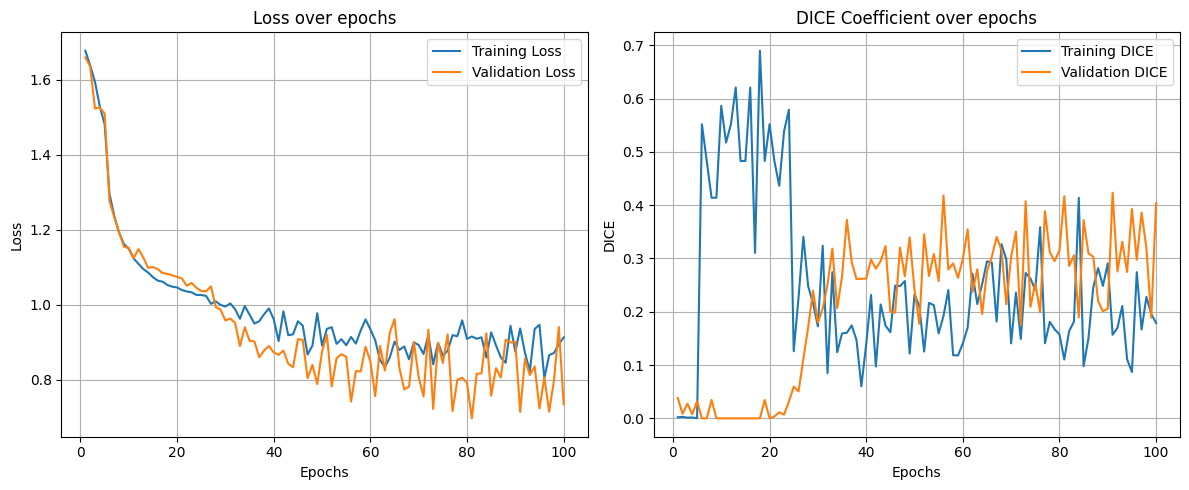

In [120]:
epochs_list = list(range(1, config['epochs'] + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, valid_losses, label='Validation Loss')
# plt.xticks(ticks=list(range(1, config['epochs'] + 1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, valid_dcs, label='Validation DICE')
# plt.xticks(ticks=list(range(1, config['epochs'] + 1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()